# Prerequisites
All computational and statistics packages have been tested in Anaconda environment (python 3.6)
1. Install Anaconda
https://www.anaconda.com/download/#linux
2. Install Spark and Java 8
https://medium.com/@GalarnykMichael/install-spark-on-ubuntu-pyspark-231c45677de0  

***Install "pyspark"***

In [1]:
try:
    print('Trying to import pyspark...')
    import pyspark
except ImportError:
    print('Pyspark import failed...')
    print('Installing pyspark in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} pyspark

Trying to import pyspark...


***Create Spark Context***
If you enqounter any error, try to reconfigure Spark on your machine (link in the first cell - .bashrc file configuration).

In [2]:
from pyspark import SparkConf, SparkContext
try:
    sc
except NameError:
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)
else:
    if sc != None:
        sc.stop()
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)

In [3]:
# from pyspark import SparkConf, SparkContext
# conf = SparkConf().setAppName('SDN').setMaster('spark://10.0.2.15:7077').setSparkHome('/usr/local/spark/') 
# sc = SparkContext(conf=conf)

Create SQL context for spark computation.

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
from os import system
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import time
import scipy.stats as sts

from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.triggers.interval import IntervalTrigger
import matplotlib.dates as mdates
import json
import urllib
import logging, sys

Paramiko installation

In [6]:
try:
    print('Trying to import paramiko...')
    import paramiko
    print('Paramiko imported.')
except ImportError:
    print('Paramiko import failed...')
    print('Installing paramiko in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} paramiko

Trying to import paramiko...
Paramiko imported.


SCP installation

In [7]:
try:
    print('Trying to import scp...')
    import scp
    print('Scp imported.')
except ImportError:
    print('Scp import failed...')
    print('Installing scp in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} scp

Trying to import scp...
Scp imported.


Keras installation

In [8]:
try:
    print('Trying to import keras...')
    import keras
    print('Keras imported.')
except ImportError:
    print('Keras import failed...')
    print('Installing keras in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} keras

Trying to import keras...


Using TensorFlow backend.


Keras imported.


In [9]:
# keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import pickle

In [10]:
def loginanddownload(hostname,uname,pwd,sfile,tfile):
    """
    Can copy files and directories from PNDa to remote system.
    Usage example:
        loginanddownload(red_pnda_ip, username, password, remote_folder, local_destination)
        loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
    
    I am using it only for download full copy of /data folder from pnda VM. There is a dependency of openssh-server
    installation on red_pnda VM.
    
    """
    try:
        print("Establishing ssh connection")
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=hostname, username=uname, password=pwd)
    except paramiko.AuthenticationException:
        print("Authentication failed, please verify your credentials: %s")
    except paramiko.SSHException as sshException:
        print("Unable to establish SSH connection: %s" % sshException)
    except paramiko.BadHostKeyException as badHostKeyException:
        print("Unable to verify server's host key: %s" % badHostKeyException)
    except Exception as e:
        print(e.args)
    try:
        print("Getting SCP Client")
        scpclient = scp.SCPClient(ssh_client.get_transport())
        print("Hostname: %s", hostname)
        print("source file: %s", sfile)
        print("target file: %s", tfile)
        scpclient.get(sfile,tfile, recursive = True)
    except scp.SCPException as e:
        print("Operation error: %s", e) 

In [11]:
# load json and create model
from keras.models import model_from_json
import keras.backend as K
from sklearn.preprocessing import StandardScaler

In [12]:
class Neural_Net:
    """Neural network class which loads already learned model based on previous traffic from network.
        Based on that model we can compute uncertenity intervals. For more details plese refer to:
        http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html"""
    
    def __init__(self, model_name, n_steps, n_length, N, l):
        """Loads model, initiates variables for uncertenity intervals computation."""
        # load model from json
        json_file = open('{}.json'.format(model_name), 'r')
        self.model = json_file.read()
        json_file.close()
        self.model = model_from_json(self.model)
        # load weights into new model
        self.model.load_weights("{}.h5".format(model_name))
        print("Loaded model from disk")
        
        """All below variables are defined based on already learned model."""
        # define probability for dropout in each layer with weight_decay 
        # and l - prior length scale, N - number of leanring samples
        self.n_steps = n_steps # number of periods on which we based our prediction
        self.n_length = n_length # period length in minutes
        self.n_input = self.n_length * self.n_steps # define the total minutes to use as input
        self.p_dense = 0.05
        self.l = l
        self.weight_decay = self.l**2/(self.n_input)
        self.N = N

        # computes tau for variance correction
        self.tau = self.l**2 * (1 - self.p_dense) / (2 * self.N * self.weight_decay)
        self.tau = self.tau**-1
        
        """For uncertanity prediction we need to approximate our nonlinear neural network
            with Gaussian Process. Training phase consisted of randomly dropping neurons from all layers
            with propability p_dense and using L2 regularization with weight_decay.
            Using random dropout on each layer we can mathematically say that our predictions are 
            almost normally distributed.
            If we want to approximate any GaussianNN we need to use dropout the same way in prediction phase
            as we used it in training phase.
            In that case we need to slightly manipulate loaded model by enabling dopout in prediction phase.
            See lines below."""
        # defines predict function from keras backend (tensorflow)
        # self.model.layers[0].input - take input shape as as it was defined in first layer
        # K.learning_phase() - if == 1 (activate droupout from learning phase)
        # self.model.layers[-1].output - produce output vector as it was defined (shape)
        self.f = K.function([self.model.layers[0].input, K.learning_phase()], [self.model.layers[-1].output])
        
        # load initial data scaler
        if 'second' in model_name:
            with open('/home/amadeusz/Documents/SDN_with_Neural_Network/scaler_sec_final.pkl', 'rb') as f:
                self.scaler = pickle.load(f)
        else:
            with open('/home/amadeusz/Documents/SDN_with_Neural_Network/scaler_final_diff_l.pkl', 'rb') as f:
                self.scaler = pickle.load(f)
        
        self.predictions = list()
        self.uncertenity = list()
        self.pred = list()
        self.unc = list()
        self.unc_up = list()
        self.unc_down = list()
    
    def predict_with_uncertainty(self, x, n_iter=10):
        result = np.zeros((n_iter,) + (x.shape[3],))

        for i in range(n_iter):
            result[i] = self.f([x, 1])[0].reshape(self.n_length)

        prediction = result.mean(axis=0)
        uncertainty = result.var(axis=0)
#         print(uncertainty)
#         uncertainty += self.tau
        return prediction, uncertainty
    
    
    def forecast(self, history):
        # standardize input data
        standardized = self.scaler.transform(history)
        # flatten data
        data = np.array(standardized)
        data = data.reshape((data.shape[0], 1))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, 0]
        # reshape into [samples, time steps, rows, cols, channels]
        input_x = input_x.reshape((1, self.n_steps, 1, self.n_length, 1))
        yhat, uncer = self.predict_with_uncertainty(input_x)
        return yhat, uncer
    
    def make_forecast(self, history):
        # reset predictions
        self.pred = list()
        self.unc = list()
        self.predictions = list()
        self.uncertenity = list()
#         history = [x for x in train]
        # predict one period
        yhat_sequence, uncert = self.forecast(history)
        # store the predictions
        self.predictions.append(yhat_sequence)
        self.uncertenity.append(uncert)
        self.predictions = np.array(self.predictions)
        self.uncertenity = np.array(self.uncertenity)
        # translate into lists
#         test_ = list()
        for i in self.predictions.reshape(self.predictions.shape[0]*self.predictions.shape[1]).tolist():
            self.pred.append(i)
        for i in self.uncertenity.reshape(self.uncertenity.shape[0]*self.uncertenity.shape[1]).tolist():
            self.unc.append(i)
            
        self.unc = np.sqrt(self.scaler.inverse_transform(np.array(self.unc))) # sigma
        
        
#         self.unc_up = self.scaler.inverse_transform(np.array(self.pred) + np.array(self.unc))
#         self.unc_down = self.scaler.inverse_transform(np.array(self.pred) - np.array(self.unc))
        
#         self.unc_up += self.tau
#         self.unc_down -= self.tau
        
        self.pred = self.scaler.inverse_transform(self.pred)
#         self.unc = self.scaler.inverse_transform(self.unc)
        
#         return self.pred, self.unc_up, self.unc_down
        return self.pred, self.unc, self.tau
#         for i in test.reshape(test.shape[0]*test.shape[1]).tolist():
#             test_.append(i)

In [13]:
class Prediction:
    """
    Prediction class - class for preprocessing data from red_pnda.
    Not full variables are in use (this is a changed copy of Lecturer shared file)
    
    Prediction class takes exacly one argument - bytes (network traffic data)
    It is further processed and returned in other format.
    
    """
    def __init__(self, bytes_, dates, network_min, network_sec):
        self.bytes = bytes_
        self.dates = dates
        self.network_min = network_min
        self.network_sec = network_sec
#         self.predictions_min = list()
#         self.uncertenity_up_min = list()
#         self.uncertenity_down_min = list()
#         self.predictions_sec = list()
#         self.uncertenity_up_sec = list()
#         self.uncertenity_down_sec = list()
        self.predictions_min = list()
        self.sigma_min = list()
        self.tau_min = None
        self.predictions_sec = list()
        self.sigma_sec = list()
        self.tau_sec = None
        
        


    def prepare_data_for_prediction(self, interval = 'minute'):
        """
        From RAW data compute time dependency (x) and bandwidth (y).
        Find mean traffic value for each minute.
        """
        self.data = self.bytes
        self.data = pd.DataFrame(data=self.data, columns=['traffic'])
        self.data = self.data.set_index(pd.DatetimeIndex(self.dates))
#         print(self.train.head())
#         print('Shape: {}'.format(self.train.shape))
        if interval == 'minute':
            self.data = self.data.groupby(pd.Grouper(freq='Min')).mean()
        elif interval == 'second':
            pass
#         print(self.train.head())
#         print('Shape: {}'.format(self.train.shape))

    def proceed_prediction(self, interval = 'min'):
        """
        Start data preprocessing.
        """
        if interval == 'minute':
            self.prepare_data_for_prediction('minute')
#             self.predictions_min, self.uncertenity_up_min, self.uncertenity_down_min = self.network_min.make_forecast([x for x in self.data.values])
            self.predictions_min, self.sigma_min, self.tau_min = self.network_min.make_forecast([x for x in self.data.values])

        elif interval == 'second':
            self.prepare_data_for_prediction('second')
#             self.predictions_sec, self.uncertenity_up_sec, self.uncertenity_down_sec = self.network_sec.make_forecast([x for x in self.data.values])
            self.predictions_sec, self.sigma_sec, self.tau_sec = self.network_sec.make_forecast([x for x in self.data.values])


In [66]:
class WatchDog:
    """
    WatchDog class - extracts bandwidth information from collected flow and port data.
    (Not all variables are in use)
    
    self.dpid - particular switch identification number
    self.port_no - particular port number on the switch
    """
    def __init__(self, data_path):    
        self.interval = 60 # co ile sekund sprawdzam czy nie ma anomalii
        self.network_min = None
        self.network_sec = None
        self.unusual_sec_3sig = [0, False]
        self.unusual_min_3sig = [0, False]
        self.unusual_sec_sig = [0, False]
        self.unusual_min_sig = [0, False]
        self.normal_work = True
        self.train_data = None
        self.pred = None
        self.pi = None
        self.current_stats = None
#         self.sched = BackgroundScheduler()
#         self.sched.start()
        self.dpid = 2
        self.port_no = 2
        self.resampled = None
        self.data_path = data_path
        
    def get_last_hour_stats(self):
        """
        Currently not in use.
        """
        last_hour_time = datetime.now() - timedelta(hours = 1)
        year = int(last_hour_time.strftime("%Y"))
        month = int(last_hour_time.strftime("%m"))
        day = int(last_hour_time.strftime("%d"))
        hour = int(last_hour_time.strftime("%H"))
        self.train_data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
        
    def get_previous_stats(self):
        """
        Gather statistics from particular hour/day.
        You can change dates based on your gathered data.
        """
#         year="2019"
#         month="1"
#         day="4"
#         hour=0
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d")) - 5
        hour = int(time.strftime("%H"))
        roznica = 0
        d = list()
        if hour - 5 < 0: # jezeli 5 godzin temu to byl inny dzien
            day -= 1 # zmien dzien na wczoraj
            roznica = np.abs(hour - 5) # policz roznice w godzinach
            hour = 24 + (hour - 5) # policz godzine jaka byla 5 godzin temu, skaluj do wczorajszej 24-ki
            # pobierz dane z konkretnej godziny wczoraj
            data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                            "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
            for i in range(1,roznica): # pobieraj dane do konca wczorajszego dnia
                h = hour + i
                d.append(sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                                  "/day="+str(day)+"/hour="+str(h)+"/dump.json"))
#                 print('h = {}'.format(h))

            for i in range(int(time.strftime("%H"))+1): # pobieraj dane od polnocy do biezacej godziny
                h = i
                d.append(sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                                  "/day="+str(day+1)+"/hour="+str(h)+"/dump.json"))
#                 print('h = {}'.format(h))
        else: # jezeli 5 godzin temu nadal bylo dzisiaj
            hour -= 5 # cofnij sie o 5 godzin i pobierz dane
            data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                            "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
            for i in range(hour+1, int(time.strftime("%H"))+1): # pobieraj dane do biezacej godziny
                h = i
                d.append(sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                                  "/day="+str(day)+"/hour="+str(h)+"/dump.json"))
#             print(d[1])

        # zcal wszystkie pobrane dane z 5-6 godzin
        for i in range(0,len(d)):
            data = data.unionAll(d[i])            
        self.train_data = data
        
        return hour
    
    def get_current_stats(self):
        """
        Currently not in use.
        """
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d")) - 5 # do usuniecia 2 !!!!!!!!!!!!!!!!!!!!!!!
        hour = int(time.strftime("%H"))
        loginanddownload('192.168.57.5', 'pnda', 'pnda', '/data/year={}/month={}/day={}/hour={}/'.format(year, 
                                                                                                         month, 
                                                                                                         day,
                                                                                                         hour),
                         '/home/amadeusz/data/year={}/month={}/day={}/'.format(year, 
                                                                               month, 
                                                                               day, 
                                                                               hour))
        
        self.current_stats = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
#         self.current_stats = sqlContext.read.json("data/year="+str(year)+"/month="+str(month)+
#                                              "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
    
    def get_port_stats(self,data,dpid,port_no):
        """
        Gathers data from specific port on the switch.
        """
        port = data.filter((data['origin']=='port_stats') & 
                           (data['switch_id']==dpid) & 
                           (data['port_no']==port_no)).orderBy('timestamp')
        port = port.toPandas()
        ts = pd.Series(port['timestamp'].astype(int))
        ts = pd.to_datetime(ts, unit='s')
        index = pd.DatetimeIndex(ts)
        raw_data = pd.Series(port['tx_bytes'].values, index=index)
        return raw_data, port
    
    def get_last_tput(self, dpid, port_no, interval):
        """
        Pobieram minute ostatniego ruchu do analizy
        """
        if interval == 'minute':
            # pobieram 13 ostatnich probek (jedna probka co 5 secund czyli chce miec 60 sekund ruchu)
            last_minute = self.current_stats.filter((self.current_stats['origin']=='port_stats') & 
                               (self.current_stats['switch_id']==dpid) & 
                               (self.current_stats['port_no']==port_no)).orderBy('timestamp', ascending=False).limit(13)
            last_minute = last_minute.toPandas()
            bytes_ = last_minute['tx_bytes'].astype(int)
            time_ = last_minute['timestamp'].astype(int)
            tput = (bytes_[0]-bytes_.iloc[-1])/(time_[0]-time_.iloc[-1]) # licze roznice w ruchu jaki byl 60s temu i teraz i dziele przez czas
        elif interval == 'second':
            # pobieram 2 ostatnie probki (jedna probka co 5 secund czyli chce miec 5 sekund ruchu, wyciagam srednia na sekunde)
            last_minute = self.current_stats.filter((self.current_stats['origin']=='port_stats') & 
                               (self.current_stats['switch_id']==dpid) & 
                               (self.current_stats['port_no']==port_no)).orderBy('timestamp', ascending=False).limit(2)
            last_minute = last_minute.toPandas()
            bytes_ = last_minute['tx_bytes'].astype(int)
            time_ = last_minute['timestamp'].astype(int)
            tput = (bytes_[0]-bytes_.iloc[-1])/(time_[0]-time_.iloc[-1]) # licze roznice w ruchu jaki byl w czasie 2s
       
        return tput*8/1e6 #Mbps (licze/zamieniam na Mbps)
        
    def resample_port_stats (self,raw_data, port, start):
        """
        Resamples data into correct date format and frequency.
        """
        raw_data = raw_data[~raw_data.index.duplicated(keep='first')]
        resampled_data = raw_data.resample('s').interpolate()
        resampled_data = [(y - x) for x,y in zip(resampled_data.values,resampled_data.values[1:])]
        ts_resampled = pd.Series(range(len(resampled_data))) + start*60*60
        ts_resampled= pd.to_datetime(ts_resampled, unit='s')
        return resampled_data, ts_resampled
    
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def check_current_traffic(self, mode):
#         loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
        hour = int(time.strftime("%H"))
        minute = int(time.strftime("%M"))
        second = int(time.strftime("%S"))
        if mode == 'minute':

            # upper and lower limits for minute prediction
#             up_min = self.pred_check_data_min.loc[(self.pred_check_data_min['hour'] == hour) & 
#                                                   (self.pred_check_data_min['minute'] == minute)]['up'].values[0]
#             down_min = self.pred_check_data_min.loc[(self.pred_check_data_min['hour'] == hour) & 
#                                                     (self.pred_check_data_min['minute'] == minute)]['down'].values[0]
            
            mean_min, sigma_min, tau_min = self.pred_check_data_min.loc[(self.pred_check_data_min['hour'] == hour) & 
                                                                        (self.pred_check_data_min['minute'] == minute)][['mean','sigma','tau']].values[0].tolist()
            
            
#             print('up: {}'.format(up_min))
#             print('down: {}'.format(down_min))
            self.get_current_stats() # pobierz dane z teraz
            cur_tput_min = self.get_last_tput(self.dpid, self.port_no, 'minute') # wyodrebnij tylko dane z danego portu na switchu
            _ = system('clear') 
            print('tput = {}'.format(cur_tput_min))
#             if cur_tput_min > up_min or cur_tput_min < down_min:
#                 print('Anomaly detected!!! (minutes interval)')
#                 self.normal_work = False
#             else:
#                 print('Normal traffic... (minutes interval)')
#                 self.normal_work = True
            # mean+4sigma > cur_tput_min > mean-4sigma > 0
            if (cur_tput_min > (mean_min + (sigma_min + tau_min)*4)) or (cur_tput_min < (mean_min - (sigma_min + tau_min)*4)) or (cur_tput_min == 0):
                print('Anomaly detected!!! (4 sigma minutes)')
                self.normal_work = False
            elif not self.normal_work:
                print('Returning to normal state. (4 sigma minutes)')
                self.normal_work = True
            # mean+3sigma > cur_tput_min > mean-3sigma
            if (cur_tput_min > (mean_min + (sigma_min + tau_min)*3)) or (cur_tput_min < (mean_min - (sigma_min + tau_min)*3)):
                if not self.unusual_min_3sig[1]: # if previously it was not an anomaly
                    self.unusual_min_3sig[0] += 1
                    self.unusual_min_3sig[1] = True
                else:
                    self.unusual_min_3sig[0] += 1
                    if self.unusual_min_3sig[0] == 4:
                        print('Anomaly detected!!! (3 sigma interval minutes)')
                        self.normal_work = False
            else:
                if self.unusual_min_3sig[1]:
                    self.unusual_min_3sig[0] = 0
                    self.unusual_min_3sig[1] = False
                    print('Returning to normal state. (3 sigma minutes)')
                    self.normal_work = True
            # mean+sigma > cur_tput_min > mean-sigma
            if (cur_tput_min > (mean_min + (sigma_min + tau_min))) or (cur_tput_min < (mean_min - (sigma_min + tau_min))):
                if not self.unusual_min_sig[1]: # if previously it was not an anomaly
                    self.unusual_min_sig[0] += 1
                    self.unusual_min_sig[1] = True
                else:
                    self.unusual_min_sig[0] += 1
                    if self.unusual_min_sig[0] == 50:
                        print('Anomaly detected!!! (sigma interval minutes)')
                        self.normal_work = False
            else:
                if self.unusual_min_sig[1]:
                    self.unusual_min_sig[0] = 0
                    self.unusual_min_sig[1] = False
                    print('Returning to normal state. (sigma minutes)')
                    self.normal_work = True
                
                
        elif mode == 'second':
            # upper and lower limits for second prediction
#             up_sec = self.pred_check_data_sec.loc[(self.pred_check_data_sec['hour'] == hour) & 
#                                                   (self.pred_check_data_sec['minute'] == minute) &
#                                                   (pred_check_data_sec['second'] == second)]['up'].values[0]
#             down_sec = self.pred_check_data_sec.loc[(self.pred_check_data_sec['hour'] == hour) & 
#                                                     (self.pred_check_data_sec['minute'] == minute) &
#                                                     (pred_check_data_sec['second'] == second)]['down'].values[0]
            
            mean_sec, sigma_sec, tau_sec = self.pred_check_data_sec.loc[(self.pred_check_data_sec['hour'] == hour) & 
                                                                        (self.pred_check_data_sec['minute'] == minute) &
                                                                        (self.pred_check_data_sec['second'] == second)][['mean','sigma','tau']].values[0].tolist()
            
    
#             print('up: {}'.format(up_sec))
#             print('down: {}'.format(down_sec))
            self.get_current_stats() # pobierz dane z teraz
            cur_tput_sec = self.get_last_tput(self.dpid, self.port_no, 'second') # wyodrebnij tylko dane z danego portu na switchu
            _ = system('clear') 
            print('tput = {}'.format(cur_tput_sec))
#             if (cur_tput_sec > up_sec or cur_tput_sec < down_sec):
#                 self.unusual += 1
#                 if self.unusual >= 50:
#                     print('Anomaly detected!!! (seconds interval)')
#                     self.normal_work = False
#             else:
#                 self.unusual = 0
#                 print('Normal traffic... (seconds interval)')
#                 self.normal_work = True

            # mean+4sigma > cur_tput_sec > mean-4sigma > 0
            if (cur_tput_sec > (mean_sec + (sigma_sec + tau_sec)*4)) or (cur_tput_sec < (mean_sec - (sigma_sec + tau_sec)*4)) or (cur_tput_sec == 0):
                print('Anomaly detected!!! (4 sigma seconds)')
                self.normal_work = False
            elif not self.normal_work:
                print('Returning to normal state. (4 sigma seconds)')
                self.normal_work = True
            # mean+3sigma > cur_tput_sec > mean-3sigma
            if (cur_tput_sec > (mean_sec + (sigma_sec + tau_sec)*3)) or (cur_tput_sec < (mean_sec - (sigma_sec + tau_sec)*3)):
                if not self.unusual_sec_3sig[1]: # if previously it was not an anomaly
                    self.unusual_sec_3sig[0] += 1
                    self.unusual_sec_3sig[1] = True
                else:
                    self.unusual_sec_3sig[0] += 1
                    if self.unusual_sec_3sig[0] == 4:
                        print('Anomaly detected!!! (3 sigma interval seconds)')
                        self.normal_work = False
            else:
                if self.unusual_sec_3sig[1]:
                    self.unusual_sec_3sig[0] = 0
                    self.unusual_sec_3sig[1] = False
                    print('Returning to normal state. (3 sigma seconds)')
                    self.normal_work = True
            # mean+sigma > cur_tput_min > mean-sigma
            if (cur_tput_sec > (mean_sec + (sigma_sec + tau_sec))) or (cur_tput_sec < (mean_sec - (sigma_sec + tau_sec))):
                if not self.unusual_sec_sig[1]: # if previously it was not an anomaly
                    self.unusual_sec_sig[0] += 1
                    self.unusual_sec_sig[1] = True
                else:
                    self.unusual_sec_sig[0] += 1
                    if self.unusual_sec_sig[0] == 50:
                        print('Anomaly detected!!! (sigma interval seconds)')
                        self.normal_work = False
            else:
                if self.unusual_sec_sig[1]:
                    self.unusual_sec_sig[0] = 0
                    self.unusual_sec_sig[1] = False
                    print('Returning to normal state. (sigma seconds)')
                    self.normal_work = True
        
            
#         if self.unusual > 2 and self.normal_work == True:
#             self.change_interval(5)
#             self.normal_work = False
#             print('changing interval to 5s')
#         elif self.unusual == 0 and self.normal_work == False:
#             self.change_interval(300)
#             self.normal_work = True
#             print('changing interval to 300s')
            
    # wystartuj observer i monitoruj/zmieniaj interval ??
    def start_stats_observer(self):
        self.sched.add_job(self.check_current_traffic, 'interval', seconds=self.interval)

    def change_job_interval(self,interval):
        print("Rescheduling stat request to %i seconds", interval)
        for s in self.sched.get_jobs():
            print('rescheduling job %s', s.id)
            it = IntervalTrigger(seconds=interval)
            self.sched.reschedule_job(s.id, trigger=it)

    def change_interval(self, interval):
        print("changing interval to %i" % interval)
        self.send_stats_interval(interval)
        self.change_job_interval(interval)
        
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    
    
    
    def proceed_prediction(self, enable_plot, mode, plot_prediction):
        """
        Start preprocessing traffic data.
        
        If you want to download data to your localhost just uncomment first line.
        This is not necessary when you have all the data stored locally already.
        """
#         loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d"))
#         loginanddownload('192.168.57.5', 'pnda', 'pnda', '/data/year={}/month={}/day={}/'.format(year, month, day),
#                          '/home/amadeusz/data/year={}/month={}/'.format(year, month, day))
#         self.get_current_stats()
        if self.network_min is None and self.network_sec is None:
            self.network_min = Neural_Net('/home/amadeusz/Documents/SDN_with_Neural_Network/model_standardise_with_l_higher_wd_bayasian_RNN', 10, 30, 240, 1e-1) # loads neural network model minutes
            self.network_sec = Neural_Net('/home/amadeusz/Documents/SDN_with_Neural_Network/model_standardise_seconds_l_bayasian_RNN', 10, 60, 1440, 1e-1) # loads neural network model seconds
        
        start = self.get_previous_stats() # pobierz 5 godzin ruchu od teraz wstecz
        data, port_stats = self.get_port_stats(self.train_data, self.dpid, self.port_no) # wydziel ruch z danego portu
        resampled_data, ts_resampled = self.resample_port_stats(data, port_stats, start) # przygotuj dane
        
        # test (jezeli robie bez wlaczonej kafki, musze usunac dopelnienie do godziny ruchu bo mam juz pobrany)
        minute = 60 - int(time.strftime("%M"))
        resampled_data = resampled_data[:-minute*60]
        ts_resampled = ts_resampled[:-minute*60]
    
        self.ts_resampled = ts_resampled # store time vector
        self.resampled = [x*8/1e6 for x in resampled_data] # zamien na Mbps (nadal w przedzialach sekundowych)

        prediction = Prediction(self.resampled, ts_resampled, self.network_min, self.network_sec) # prepare data for prediction
        if mode == 'minute':
            prediction.proceed_prediction('minute') # make 30 minutes prediction
        elif mode == 'second':
            prediction.proceed_prediction('second') # make 60 seconds prediction
        
        # plotting part (plots 5 hours back and predicted mean with uncertenity)
        if enable_plot:
            if mode == 'minute':
#                 fig = plt.figure(figsize=(15,8))
#                 ax = fig.add_subplot(111)
                # resample 5 hour data from seconds into minutes
                ixy = pd.DataFrame(data=[x*8/1e6 for x in resampled_data], columns=['traffic'])
                ixy = ixy.set_index(pd.DatetimeIndex(ts_resampled))
                ixy = ixy.groupby(pd.Grouper(freq='Min')).mean()
                # 
                new_pred = prediction.predictions_min.tolist()
#                 new_unc_up = prediction.uncertenity_up_min.tolist()
#                 new_unc_down = prediction.uncertenity_down_min.tolist()
                new_sigma_min = prediction.sigma_min.tolist()
                for position, i in enumerate(ixy.values.tolist()):
                    new_pred.insert(position,i[0])
#                     new_unc_up.insert(position,i[0])
#                     new_unc_down.insert(position,i[0])
                    new_sigma_min.insert(position,i[0])
                # creates datetime range for plots
                if self.ts_resampled.iloc[-1].minute + 30 < 60:
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[0].year,
                                                                       self.ts_resampled.iloc[0].month,
                                                                       self.ts_resampled.iloc[0].day,
                                                                       self.ts_resampled.iloc[0].hour,
                                                                       self.ts_resampled.iloc[0].minute), 
                                      end='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     self.ts_resampled.iloc[-1].day,
                                                                     self.ts_resampled.iloc[-1].hour,
                                                                     self.ts_resampled.iloc[-1].minute+30), 
                                      freq="1min")
                else:
                    print('jednak tutaj weszlo')
                    if self.ts_resampled.iloc[-1].hour+1 >= 24:
                        hour = 0
                        day = self.ts_resampled.iloc[-1].day + 1
                    else:
                        hour = self.ts_resampled.iloc[-1].hour+1
                        day = self.ts_resampled.iloc[-1].day
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[0].year,
                                                                       self.ts_resampled.iloc[0].month,
                                                                       self.ts_resampled.iloc[0].day,
                                                                       self.ts_resampled.iloc[0].hour,
                                                                       self.ts_resampled.iloc[0].minute), 
                                      end='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     day,
                                                                     hour,
                                                                     (self.ts_resampled.iloc[-1].minute+30) - 60), 
                                      freq="1min")
                x2 = pd.date_range(start='{}'.format(self.ts_resampled.iloc[0]), 
                                      end='{}'.format(self.ts_resampled.iloc[-1]), 
                                      freq="1min")

                self.pred_check_data_min = pd.DataFrame(data=np.full(len(new_sigma_min), prediction.tau_min), 
                                                    columns=['tau'])

#                 self.pred_check_data_min['up'] = new_unc_up
#                 self.pred_check_data_min['down'] = new_unc_down
                self.pred_check_data_min['sigma'] = new_sigma_min
                self.pred_check_data_min['mean'] = new_pred
                self.pred_check_data_min['hour'] = [p.hour for p in pd.to_datetime(x1)]
                self.pred_check_data_min['minute'] = [p.minute for p in pd.to_datetime(x1)]
                
                if plot_prediction:
#                     ax.plot(x1, new_pred, 'g') # plot prediction mean
#                     ax.fill_between(x1, new_unc_up, new_unc_down, facecolor='yellow') # plot prediction uncertenity interval
                    
                    new_pred = prediction.predictions_min.tolist()
                    new_sigma_min = prediction.sigma_min.tolist()
                    new_4sigma_min_up = np.asarray(new_pred) + (np.asarray(new_sigma_min) + prediction.tau_min)*4
                    new_4sigma_min_up = new_4sigma_min_up.tolist()
                    new_4sigma_min_down = np.asarray(new_pred) - (np.asarray(new_sigma_min) + prediction.tau_min)*4
                    new_4sigma_min_down = new_4sigma_min_down.tolist()
                    new_3sigma_min_up = np.asarray(new_pred) + (np.asarray(new_sigma_min) + prediction.tau_min)*3
                    new_3sigma_min_up = new_3sigma_min_up.tolist()
                    new_3sigma_min_down = np.asarray(new_pred) - (np.asarray(new_sigma_min) + prediction.tau_min)*3
                    new_3sigma_min_down = new_3sigma_min_down.tolist()
                    new_sigma_min_up = np.asarray(new_pred) + (np.asarray(new_sigma_min) + prediction.tau_min)
                    new_sigma_min_up = new_sigma_min_up.tolist()
                    new_sigma_min_down = np.asarray(new_pred) - (np.asarray(new_sigma_min) + prediction.tau_min)
                    new_sigma_min_down = new_sigma_min_down.tolist()
                    
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x1[-len(new_pred):], new_pred, 'g', label = 'predicted mean') # plot prediction mean
                    # 4*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_4sigma_min_up, 
                                    new_4sigma_min_down, 
                                    facecolor='red', 
                                    alpha=0.2,
                                    label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_3sigma_min_up, 
                                    new_3sigma_min_down, 
                                    facecolor='red', 
                                    alpha=0.4,
                                    label = '3 sigma')
                    # sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_sigma_min_up, 
                                    new_sigma_min_down, 
                                    facecolor='red', 
                                    alpha=0.7,
                                    label = 'sigma')
                    ax.legend()
                    ax.set_title('Predicted 30 minutes with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    ax.set_xlabel('hour:min')
                    ax.set_ylim(bottom = 0)
                    
                    for position, i in enumerate(ixy.values.tolist()):
                        new_pred.insert(position,i[0])
                        new_4sigma_min_up.insert(position,i[0])
                        new_4sigma_min_down.insert(position,i[0])
                        new_3sigma_min_up.insert(position,i[0])
                        new_3sigma_min_down.insert(position,i[0])
                        new_sigma_min_up.insert(position,i[0])
                        new_sigma_min_down.insert(position,i[0])
                        
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                        
                    ax.plot(x1, new_pred, 'g', label = 'predicted mean') # plot prediction mean
                    # 4*sigma
                    ax.fill_between(x1, 
                                    new_4sigma_min_up, 
                                    new_4sigma_min_down, 
                                    facecolor='red', alpha=0.2, label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1, 
                                    new_3sigma_min_up, 
                                    new_3sigma_min_down, 
                                    facecolor='red', alpha=0.4, label = '3 sigma')
                    # sigma
                    ax.fill_between(x1, 
                                    new_sigma_min_up, 
                                    new_sigma_min_down, 
                                    facecolor='red', alpha=0.7, label = 'sigma')
                    
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('5 hours traffic and predicted 30 min with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    ax.set_xlabel('hour:min')
                    ax.set_ylim(bottom = 0)
                else:
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('5 hours traffic and predicted 30 min with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    ax.set_xlabel('hour:min')
                    ax.set_ylim(bottom = 0)
                
            elif mode == 'second':
                # seconds part
#                 fig = plt.figure(figsize=(15,8))
#                 ax = fig.add_subplot(111)
                # resample 5 hour data from seconds into minutes
                ixy = pd.DataFrame(data=[x*8/1e6 for x in resampled_data][-600:], columns=['traffic'])
                ixy = ixy.set_index(pd.DatetimeIndex(ts_resampled[-600:]))
                # 
                new_pred = prediction.predictions_sec.tolist()
#                 new_unc_up = prediction.uncertenity_up_sec.tolist()
#                 new_unc_down = prediction.uncertenity_down_sec.tolist()
                new_sigma_sec = prediction.sigma_sec.tolist()
                for position, i in enumerate(ixy.values.tolist()):
                    new_pred.insert(position,i[0])
#                     new_unc_up.insert(position,i[0])
#                     new_unc_down.insert(position,i[0])
                    new_sigma_sec.insert(position,i[0])
                # creates datetime range for plots
                if self.ts_resampled.iloc[-1].minute + 1 < 60:
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-600].year,
                                                                       self.ts_resampled.iloc[-600].month,
                                                                       self.ts_resampled.iloc[-600].day,
                                                                       self.ts_resampled.iloc[-600].hour,
                                                                       self.ts_resampled.iloc[-600].minute,
                                                                       self.ts_resampled.iloc[-600].second), 
                                      end='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     self.ts_resampled.iloc[-1].day,
                                                                     self.ts_resampled.iloc[-1].hour,
                                                                     self.ts_resampled.iloc[-1].minute+1,
                                                                     self.ts_resampled.iloc[-1].second), 
                                      freq="1S")
                else:
                    print('jednak tutaj weszlo')
                    if self.ts_resampled.iloc[-1].hour+1 >= 24:
                        hour = 0
                        day = self.ts_resampled.iloc[-1].day + 1
                    else:
                        hour = self.ts_resampled.iloc[-1].hour+1
                        day = self.ts_resampled.iloc[-1].day
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-600].year,
                                                                       self.ts_resampled.iloc[-600].month,
                                                                       self.ts_resampled.iloc[-600].day,
                                                                       self.ts_resampled.iloc[-600].hour,
                                                                       self.ts_resampled.iloc[-600].minute,
                                                                       self.ts_resampled.iloc[-600].second), 
                                      end='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     day,
                                                                     hour,
                                                                     '00',
                                                                     self.ts_resampled.iloc[-1].second), 
                                      freq="1S")
                x2 = pd.date_range(start='{}'.format(self.ts_resampled.iloc[-600]), 
                                      end='{}'.format(self.ts_resampled.iloc[-1]), 
                                      freq="1S")

                self.pred_check_data_sec = pd.DataFrame(data=np.full(len(new_sigma_sec), prediction.tau_sec), 
                                                    columns=['tau'])

#                 self.pred_check_data_sec['up'] = new_unc_up
#                 self.pred_check_data_sec['down'] = new_unc_down
                self.pred_check_data_sec['sigma'] = new_sigma_sec
                self.pred_check_data_sec['mean'] = new_pred
                self.pred_check_data_sec['hour'] = [p.hour for p in pd.to_datetime(x1)]
                self.pred_check_data_sec['minute'] = [p.minute for p in pd.to_datetime(x1)]
                self.pred_check_data_sec['second'] = [p.second for p in pd.to_datetime(x1)]
                
                if plot_prediction:
                    new_pred = prediction.predictions_sec.tolist()
                    new_sigma_sec = prediction.sigma_sec.tolist()
                    new_4sigma_sec_up = np.asarray(new_pred) + (np.asarray(new_sigma_sec) + prediction.tau_sec)*4
                    new_4sigma_sec_up = new_4sigma_sec_up.tolist()
                    new_4sigma_sec_down = np.asarray(new_pred) - (np.asarray(new_sigma_sec) + prediction.tau_sec)*4
                    new_4sigma_sec_down = new_4sigma_sec_down.tolist()
                    new_3sigma_sec_up = np.asarray(new_pred) + (np.asarray(new_sigma_sec) + prediction.tau_sec)*3
                    new_3sigma_sec_up = new_3sigma_sec_up.tolist()
                    new_3sigma_sec_down = np.asarray(new_pred) - (np.asarray(new_sigma_sec) + prediction.tau_sec)*3
                    new_3sigma_sec_down = new_3sigma_sec_down.tolist()
                    new_sigma_sec_up = np.asarray(new_pred) + (np.asarray(new_sigma_sec) + prediction.tau_sec)
                    new_sigma_sec_up = new_sigma_sec_up.tolist()
                    new_sigma_sec_down = np.asarray(new_pred) - (np.asarray(new_sigma_sec) + prediction.tau_sec)
                    new_sigma_sec_down = new_sigma_sec_down.tolist()
                    
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x1[-len(new_pred):], new_pred, 'g', label = 'predicted mean') # plot prediction mean
                    # 4*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_4sigma_sec_up, 
                                    new_4sigma_sec_down, 
                                    facecolor='red', 
                                    alpha=0.2,
                                    label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_3sigma_sec_up, 
                                    new_3sigma_sec_down, 
                                    facecolor='red', 
                                    alpha=0.4,
                                    label = '3 sigma')
                    # sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_sigma_sec_up, 
                                    new_sigma_sec_down, 
                                    facecolor='red', 
                                    alpha=0.7,
                                    label = 'sigma')
                    ax.legend()
                    ax.set_title('Predicted 60 seconds with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
                    ax.set_xlabel('min:sec')
                    ax.set_ylim(bottom = 0)
                    
                    for position, i in enumerate(ixy.values.tolist()):
                        new_pred.insert(position,i[0])
                        new_4sigma_sec_up.insert(position,i[0])
                        new_4sigma_sec_down.insert(position,i[0])
                        new_3sigma_sec_up.insert(position,i[0])
                        new_3sigma_sec_down.insert(position,i[0])
                        new_sigma_sec_up.insert(position,i[0])
                        new_sigma_sec_down.insert(position,i[0])
                        
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    
                    
                    ax.plot(x1, new_pred, 'g', label = 'predicted mean') # plot prediction mean
#                     ax.fill_between(x1, new_unc_up, new_unc_down, facecolor='yellow') # plot prediction uncertenity interval
                    # 4*sigma
                    ax.fill_between(x1, 
                                    new_4sigma_sec_up, 
                                    new_4sigma_sec_down, 
                                    facecolor='red', alpha=0.2, label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1, 
                                    new_3sigma_sec_up, 
                                    new_3sigma_sec_down, 
                                    facecolor='red', alpha=0.4, label = '3 sigma')
                    # sigma
                    ax.fill_between(x1, 
                                    new_sigma_sec_up, 
                                    new_sigma_sec_down, 
                                    facecolor='red', alpha=0.7, label = 'sigma')
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('600 seconds traffic and predicted 60 sec with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
                    ax.set_xlabel('min:sec')
                    ax.set_ylim(bottom = 0)
                else:
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('600 seconds traffic and predicted 60 sec with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
                    ax.set_xlabel('min:sec')
                    ax.set_ylim(bottom = 0)

In [64]:
np.full(10, 7)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [ ]:
wd.ts_resampled.tail()

In [ ]:
wd = WatchDog("/home/amadeusz/")
wd.check_current_traffic()

***Load the data***
Preprocessed data will be stored in wd.resampled

In [36]:
loginanddownload('192.168.57.5', 'pnda', 'pnda', '/data', '/home/amadeusz/')

Establishing ssh connection
Getting SCP Client
Hostname: %s 192.168.57.5
source file: %s /data
target file: %s /home/amadeusz/


Loaded model from disk
Loaded model from disk


/home/amadeusz/anaconda3/envs/nowe/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


13.912277936935425
3.919049024581909


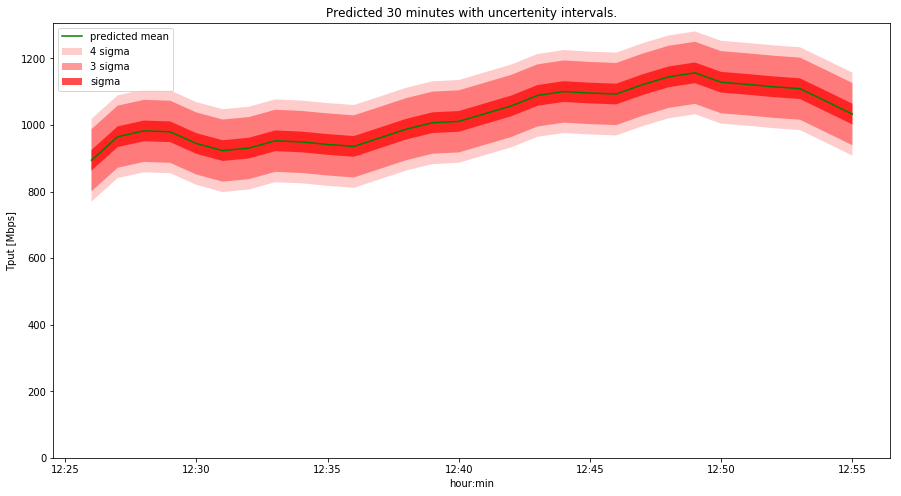

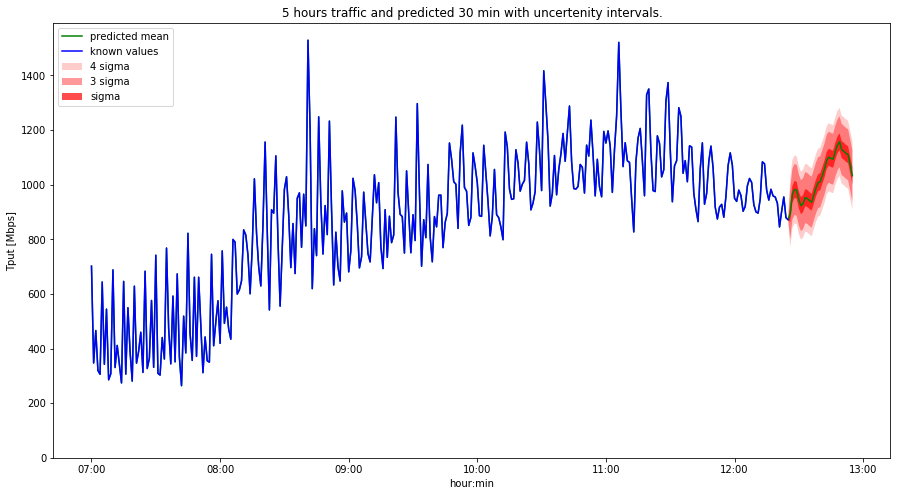

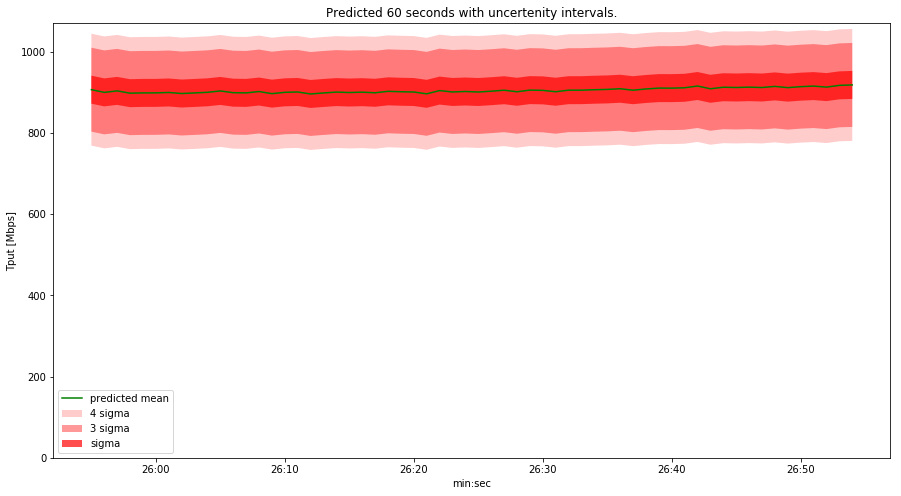

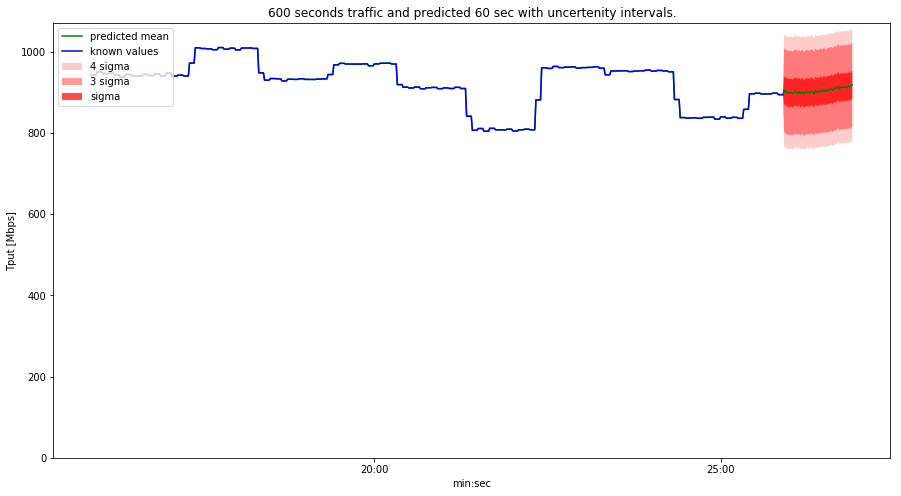

In [67]:
# please specify path to data folder
%matplotlib inline
wd = WatchDog("/home/amadeusz/")
start = time.time()
wd.proceed_prediction(enable_plot = True, mode = 'minute', plot_prediction = True)
end = time.time()
print(end-start)
start = time.time()
wd.proceed_prediction(enable_plot = True, mode = 'second', plot_prediction = True)
end = time.time()
print(end-start)